## Customer Segmentation with RFM engineering

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from scipy import stats

# Import Sparksession
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql.window import Window

# Import Sparks MlLib
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.linalg import Vectors, VectorUDT

import warnings
warnings.filterwarnings('ignore')

spark = SparkSession.builder.appName("RFM Clustering")\
        .config("spark.memory.offHeap.enabled","true")\
        .config("spark.memory.offHeap.size","10g")\
        .getOrCreate()

spark.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")

In [2]:
# Define the path to the folder
folder_path = "Dataset/Cleaned"

# Load all CSV files in the folder
rfm = spark.read.format('csv').option('header','true').option('inferSchema','true').load(folder_path)

rfm.show(5)

+-----------+---------------+---------------------+-------------+---------+------------+----------------+---------------------------------+-------------------+----+-----+------------+------+
|Customer ID|Customer Status|Date Order was placed|Delivery Date| Order ID|  Product ID|Quantity Ordered|Total Retail Price for This Order|Cost Price Per Unit|Year|Month|Retail Price|Profit|
+-----------+---------------+---------------------+-------------+---------+------------+----------------+---------------------------------+-------------------+----+-----+------------+------+
|        579|         Silver|           2017-01-01|   2017-01-07|123002578|220101400106|               2|                             92.6|               20.7|2017|    1|        46.3|  51.2|
|       7574|         Silver|           2017-01-01|   2017-01-05|123004074|210201000009|               1|                             21.7|               9.95|2017|    1|        21.7| 11.75|
|      28861|           Gold|           2017-

In [3]:
rfm.printSchema()

root
 |-- Customer ID: integer (nullable = true)
 |-- Customer Status: string (nullable = true)
 |-- Date Order was placed: string (nullable = true)
 |-- Delivery Date: string (nullable = true)
 |-- Order ID: integer (nullable = true)
 |-- Product ID: long (nullable = true)
 |-- Quantity Ordered: integer (nullable = true)
 |-- Total Retail Price for This Order: double (nullable = true)
 |-- Cost Price Per Unit: double (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Retail Price: double (nullable = true)
 |-- Profit: double (nullable = true)



In [4]:
# Preprocessing data in accordance with the previous explanation.
rfm = (rfm
            .withColumn("Date Order was placed", to_date(col("Date Order was placed")))
            .withColumn("Delivery Date", to_date(col("Delivery Date")))
)

rfm.show(10)

+-----------+---------------+---------------------+-------------+---------+------------+----------------+---------------------------------+-------------------+----+-----+------------+------+
|Customer ID|Customer Status|Date Order was placed|Delivery Date| Order ID|  Product ID|Quantity Ordered|Total Retail Price for This Order|Cost Price Per Unit|Year|Month|Retail Price|Profit|
+-----------+---------------+---------------------+-------------+---------+------------+----------------+---------------------------------+-------------------+----+-----+------------+------+
|        579|         Silver|           2017-01-01|   2017-01-07|123002578|220101400106|               2|                             92.6|               20.7|2017|    1|        46.3|  51.2|
|       7574|         Silver|           2017-01-01|   2017-01-05|123004074|210201000009|               1|                             21.7|               9.95|2017|    1|        21.7| 11.75|
|      28861|           Gold|           2017-

In [5]:
rfm.count()

185013

RFM is a basic customer segmentation algorithm based on their purchasing behaviour. The behaviour is identified by using only three customer data points:
1. Recency: How recently has each customer made a purchase?
2. Frequency: How often have they bought something?
3. Monetary Value: How much money do they spend on average when making purchases?

In [6]:
# Reference date for calculating recency
target_date = rfm.agg(max('Date Order was placed')).first()[0] + dt.timedelta(days=1)
display(target_date)

# Create rfm dataframe with recency calculation
rfm = rfm.withColumn("Recency", datediff(lit(target_date), col("Date Order was placed")))

datetime.date(2022, 1, 1)

In [33]:
# Aggregate the data by Customer ID, and find min Recency, Order Count, and sum the total sales
rfm_table = (rfm
        .groupBy("Customer ID")
        .agg(min("Recency").alias("Recency"),
             count("Order ID").alias("Frequency"),
             sum("Total Retail Price for This Order").alias("Monetary"))
)

rfm = rfm.join(rfm_table['Customer ID', 'Frequency', 'Monetary'], 'Customer ID', 'inner')

rfm_table.show(5)

+-----------+-------+---------+------------------+
|Customer ID|Recency|Frequency|          Monetary|
+-----------+-------+---------+------------------+
|      54264|    943|        3|360.59999999999997|
|      40335|   1457|        4|             531.3|
|      35071|     53|        7|            2373.1|
|      43302|     81|        4|             330.1|
|      35820|   1234|        2|            190.75|
+-----------+-------+---------+------------------+
only showing top 5 rows



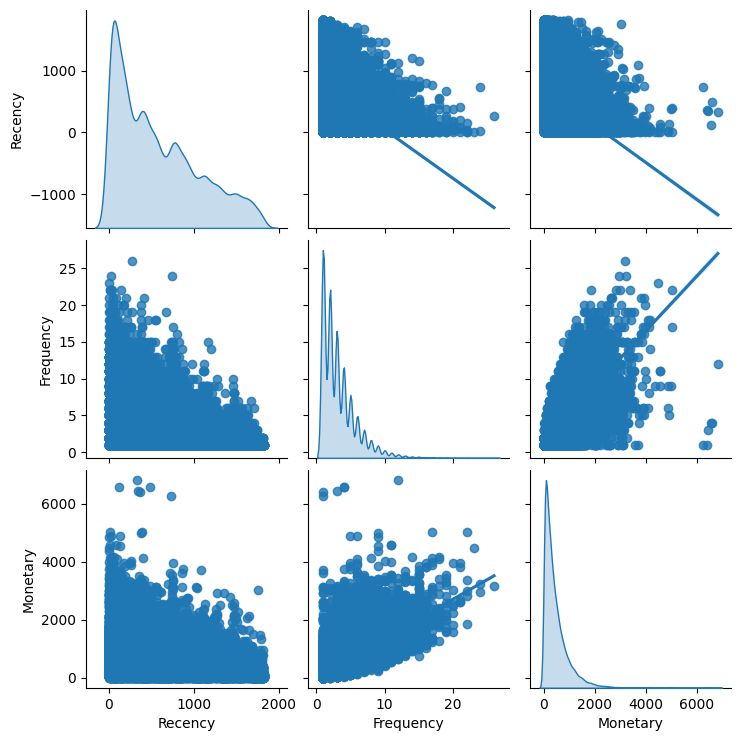

In [8]:
rfm_skew = rfm_table.toPandas()

# Build a pairplot with different x and y variables
sns.pairplot(data=rfm_skew,
        vars=["Recency", "Frequency", "Monetary"],
        kind='reg',
        diag_kind = 'kde')

plt.show()

### Normalizing the data

In [9]:
# Analyze skewnes in each features
def skewness_calc(data):
    fig, ax = plt.subplots(2, 2, figsize=(5,5))
    sns.distplot(data, ax=ax[0,0])
    sns.distplot(np.log(data), ax=ax[0,1])
    sns.distplot(np.sqrt(data), ax=ax[1,0])
    sns.distplot(stats.boxcox(data)[0], ax=ax[1,1])
    plt.tight_layout()
    plt.show()
    
    print('Log Transform : The skew coefficient of', data.skew().round(2), 'to', np.log(data).skew().round(2))
    print('Square Root Transform : The skew coefficient of', data.skew().round(2), 'to', np.sqrt(data).skew().round(2))
    print('Box-Cox Transform : The skew coefficient of', data.skew().round(2), 'to', pd.Series(stats.boxcox(data)[0]).skew().round(2))

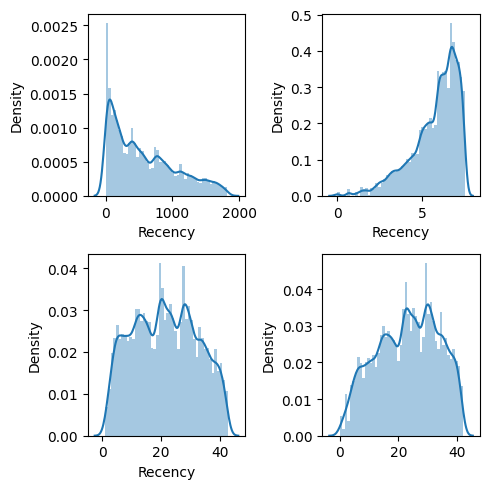

Log Transform : The skew coefficient of 0.73 to -1.16
Square Root Transform : The skew coefficient of 0.73 to 0.04
Box-Cox Transform : The skew coefficient of 0.73 to -0.18


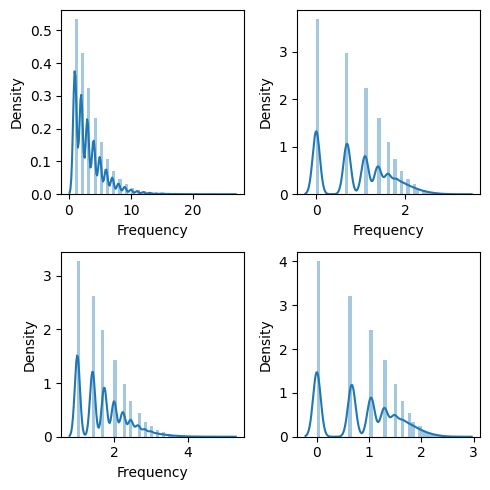

Log Transform : The skew coefficient of 1.77 to 0.14
Square Root Transform : The skew coefficient of 1.77 to 0.82
Box-Cox Transform : The skew coefficient of 1.77 to 0.03


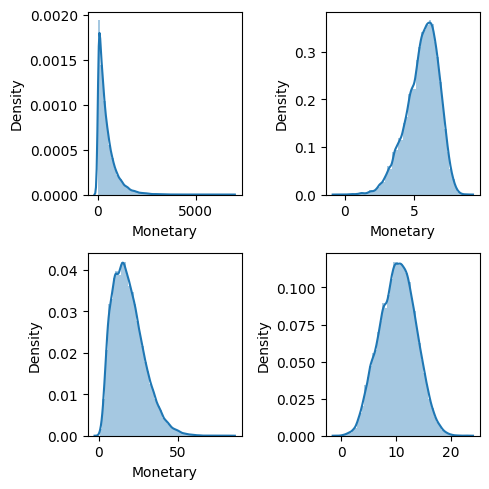

Log Transform : The skew coefficient of 2.41 to -0.61
Square Root Transform : The skew coefficient of 2.41 to 0.82
Box-Cox Transform : The skew coefficient of 2.41 to -0.03


In [10]:
for i in rfm_skew[['Recency', 'Frequency', 'Monetary']].columns:
    skewness_calc(rfm_skew[i])

As we can see, based on the skewness values, it's clear that both the Log Transform and the Box-Cox Transform have been effective at reducing skewness. Therefore, in this case, the Box-Cox transformation is likely the most suitable choice for normalizing the data.

In [11]:
# Create a new DataFrame with the Box-Cox transformed values
transformed_rfm = rfm_skew[['Customer ID']]
transformed_rfm['Recency'] = stats.boxcox(rfm_skew['Recency'])[0]
transformed_rfm['Frequency'] = stats.boxcox(rfm_skew['Frequency'])[0]
transformed_rfm['Monetary'] = stats.boxcox(rfm_skew['Monetary'])[0]

# Show the transformed DataFrame
transformed_rfm = spark.createDataFrame(transformed_rfm)
transformed_rfm.limit(5).show()

+-----------+------------------+------------------+------------------+
|Customer ID|           Recency|         Frequency|          Monetary|
+-----------+------------------+------------------+------------------+
|      54264| 31.99840706942484|1.0356469182063281| 10.87053553879488|
|      40335|38.128396891016344|1.2870502535834385|12.106344917975875|
|      35071| 9.134166817428577|1.7541717424475134|17.835643423790977|
|      43302|11.165013067293971|1.2870502535834385|10.601293780314647|
|      35820|  35.6693611454962|0.6677180577435238| 9.028133222958056|
+-----------+------------------+------------------+------------------+



## Clustering Model with K-Means Algorithm

In [12]:
# Select features that we want to scale
transformed_rfm = transformed_rfm.select(['Customer ID','Recency','Frequency','Monetary'])

# Create a VectorAssembler and outputs a new column 'features'
assemble = VectorAssembler(inputCols=[
    'Recency','Frequency','Monetary'
], outputCol= 'Features')

# Use the VectorAssembler to transform the data in the 'transformed_rfm' DataFrame
assembled_rfm = assemble.transform(transformed_rfm)

# Create, Fit and Transform a StandardScaler which consumes the 'features' column
scale = StandardScaler(inputCol='Features', outputCol='Standardized')
data_scale = scale.fit(assembled_rfm)
data_scale_output = data_scale.transform(assembled_rfm)

# Display the first two rows of the 'standardized' column
data_scale_output.select('Standardized').show(2,truncate=False)

+------------------------------------------------------+
|Standardized                                          |
+------------------------------------------------------+
|[3.085230896336685,1.6071245590308,3.3276454963787088]|
|[3.6762738801568,1.9972541170915485,3.705946592984121]|
+------------------------------------------------------+
only showing top 2 rows



#### Finding the optimal K number of clusters
When building a K-Means clustering model, we first need to determine the number of clusters or groups we want the algorithm to return. If we decide on three clusters, for instance, then we will have three customer segments. To make our clustering reach its maximum performance, we have to determine which hyperparameter fits to the data. To determine which hyperparameter is the best for our model and data, we can use the elbow method to decide.

23/10/23 22:39:45 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


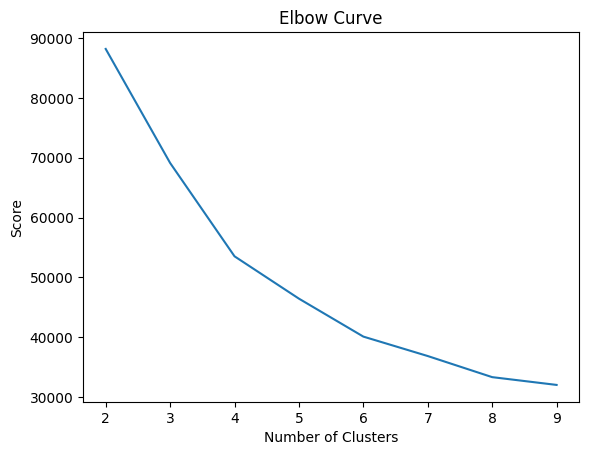

In [13]:
# Initialize an array of zeros with length 10 to store the cost of each KMeans model
cost = np.zeros(10)

# Create a ClusteringEvaluator with the specified parameters
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='Standardized', \
            metricName='silhouette', distanceMeasure='squaredEuclidean')

# Loop over the range from 2 to 10 (exclusive)
for i in range(2,10):
    KMeans_algo = KMeans(featuresCol='Standardized', k=i)
    KMeans_fit = KMeans_algo.fit(data_scale_output)
    output = KMeans_fit.transform(data_scale_output)
    cost[i] = KMeans_fit.summary.trainingCost

# Convert the cost array (from index 2 onwards) to a DataFrame
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = range(2,10)
df_cost.insert(0, 'cluster', new_col)

# Plot the cost against the number of clusters
plt.plot(df_cost.cluster, df_cost.cost)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [14]:
# Evaluate the model from k=2 to k=10
for k in range(2,10):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol('Standardized')
    model = kmeans.fit(data_scale_output)
    predictions = model.transform(data_scale_output)
    
    silhouette = evaluator.evaluate(predictions)
    print(f'Silhouette with squared euclidean distance for k={k} is {silhouette}')

Silhouette with squared euclidean distance for k=2 is 0.5810142628021554
Silhouette with squared euclidean distance for k=3 is 0.4546012185634588
Silhouette with squared euclidean distance for k=4 is 0.49735829136625026
Silhouette with squared euclidean distance for k=5 is 0.4440579608866897
Silhouette with squared euclidean distance for k=6 is 0.45214218200335027
Silhouette with squared euclidean distance for k=7 is 0.409008862892862
Silhouette with squared euclidean distance for k=8 is 0.42835303540293945
Silhouette with squared euclidean distance for k=9 is 0.42738386018629093


A higher Silhouette score indicates better-defined clusters. In your case, you've provided Silhouette scores for two different values of k (number of clusters), k=3 and k=4.

The Silhouette score for *k=4* (0.497) is higher than the Silhouette score for k=3 (0.454), which suggests that a k value of 4 is better at creating well-defined clusters based on the data. Therefore, based on the Silhouette score alone, k=4 appears to be a better choice.

In [15]:
# Create a KMeans model with 4 clusters that we've already defined
KMeans_algo = KMeans(featuresCol='Standardized', k=4)

# Fit & transform the KMeans model to the data
model = KMeans_algo.fit(data_scale_output)
predictions = model.transform(data_scale_output)

# Rename col prediction to Cluster
predictions = predictions.withColumnRenamed("prediction", "Cluster")

predictions.show(5)

+-----------+------------------+------------------+------------------+--------------------+--------------------+-------+
|Customer ID|           Recency|         Frequency|          Monetary|            Features|        Standardized|Cluster|
+-----------+------------------+------------------+------------------+--------------------+--------------------+-------+
|      54264| 31.99840706942484|1.0356469182063281| 10.87053553879488|[31.9984070694248...|[3.08523089633668...|      2|
|      40335|38.128396891016344|1.2870502535834385|12.106344917975875|[38.1283968910163...|[3.6762738801568,...|      2|
|      35071| 9.134166817428577|1.7541717424475134|17.835643423790977|[9.13416681742857...|[0.88070051788145...|      1|
|      43302|11.165013067293971|1.2870502535834385|10.601293780314647|[11.1650130672939...|[1.07651119002522...|      0|
|      35820|  35.6693611454962|0.6677180577435238| 9.028133222958056|[35.6693611454962...|[3.43917791969805...|      3|
+-----------+------------------+

In [34]:
current_status = (
    rfm
        .withColumn('Status Map', when(col('Customer Status') == 'Silver', 1)
                                 .when(col('Customer Status') == 'Gold', 2)
                                 .when(col('Customer Status') == 'Platinum', 3)
                                 .otherwise(col('Customer Status')))
        .groupBy(('Customer ID'))
        .agg(max('Status Map').alias('Current Status'))
)

rfm_df = (
    rfm_table
        .join(predictions['Customer ID', 'Cluster'], 'Customer ID', 'inner')
        .join(current_status['Customer ID', 'Current Status'], 'Customer ID', 'inner')
)

# Deep dive the clustered
(rfm_df.groupBy('Cluster')
    .agg(round(avg('Recency'),2).alias('Recency'),
         round(avg('Frequency'),2).alias('Frequency'),
         round(avg('Monetary'),2).alias('Monetary'),
         count('Customer ID').alias('Count'))
    .withColumn('Count %', round(col('Count')/rfm_df.count(),2))
    .orderBy(desc('Count %'))
    .show())

+-------+-------+---------+--------+-----+-------+
|Cluster|Recency|Frequency|Monetary|Count|Count %|
+-------+-------+---------+--------+-----+-------+
|      2| 777.47|     3.36|   494.1|15752|   0.28|
|      3|1031.86|     1.21|  115.11|15404|   0.27|
|      1| 167.15|     6.41|  984.46|13809|   0.25|
|      0| 162.53|     2.27|  225.17|11062|    0.2|
+-------+-------+---------+--------+-----+-------+



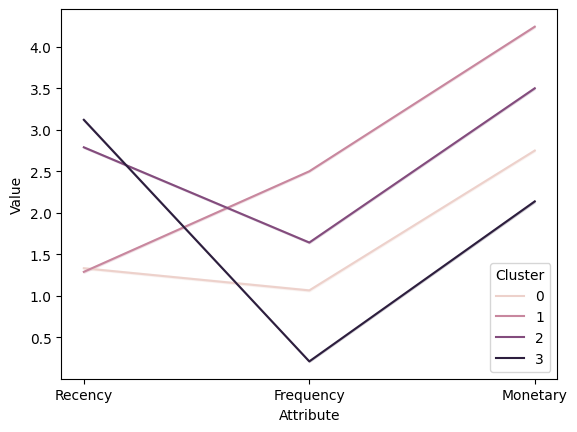

In [17]:
# Identify the columns to be melted (unpivoted)
pred = predictions.select(['Cluster', 'Standardized'])

# Define a UDF to convert the vectors to a list
list_udf = udf(lambda vector: vector.toArray().tolist(), ArrayType(DoubleType()))

# Apply the UDF to the 'Standardized' column
df = pred.withColumn('Standardized', list_udf('Standardized'))

# Split the list into separate columns
df = df.select(df['Standardized'][0].alias('Recency'), 
               df['Standardized'][1].alias('Frequency'), 
               df['Standardized'][2].alias('Monetary'),
               df['Cluster'])

df = df.toPandas()

unpivot_df = pd.melt(df.reset_index(),
                      id_vars=['Cluster'],
                      value_vars=['Recency','Frequency','Monetary'],
                      var_name='Attribute',
                      value_name='Value')

# Visualize it
sns.lineplot(x='Attribute', y='Value', hue='Cluster', data=unpivot_df)
plt.show()

#### RFM First Conclusion

| Cluster | Type of Customer |  %  | RFM Interpretaation |
| ------- | ---------------- | --- | ------------------- |
| 0       | At Risk Customer | 28% | Users who made their last transaction a while ago and who made frequent and large purchases in the past. |
| 1       | New Customer     | 27% | Users in this cluster display high recency but haven’t been seen spending much on the platform. They also don’t visit the site often. |
| 2       | Loyal Customer   | 25% | Most frequent users with the highest monetary spending amount and transact most. |
| 3       | Lost Customer    | 19% | Users who made their last transaction a long time ago, and who have made few purchases. Therefore, it could be the cluster of Lost customer/churned customers. |

In [19]:
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

fig = px.scatter_3d(df, x='Recency', y='Frequency', z='Monetary',
              color='Cluster', opacity=0.7,color_discrete_sequence=px.colors.qualitative.G10)

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

In [20]:
cluster_avg = (rfm_df.select(['Cluster','Recency','Frequency','Monetary'])
                     .groupby(['Cluster'])
                     .agg(avg('Recency').alias('Recency'),
                          avg('Frequency').alias('Frequency'),
                          avg('Monetary').alias('Monetary'))
                     .toPandas()
            )

population_avg = rfm_df.select(['Recency','Frequency','Monetary']).toPandas()
population_avg = population_avg[['Recency','Frequency','Monetary']].mean()

relative_imp = cluster_avg / population_avg - 1
relative_imp

Cluster  Frequency  Monetary   Recency
0      NaN   0.444435  0.531933 -0.104110
1      NaN  -0.741195 -0.840498  0.263504
2      NaN  -0.250369 -0.276443  0.252510
3      NaN  -0.490974 -0.671140 -0.360340

Text(0.5, 1.0, 'Relative importance of attributes')

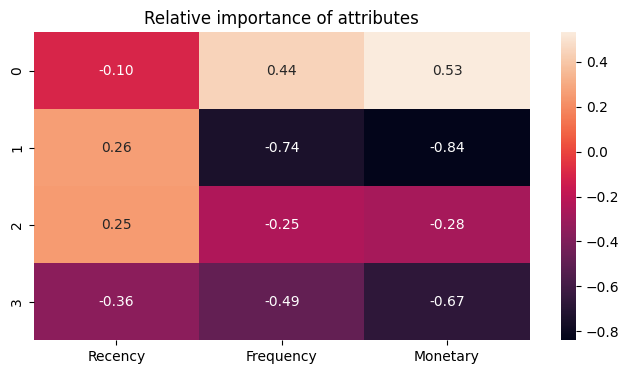

In [22]:
plt.figure(figsize=(8, 4))
sns.heatmap(data=relative_imp[['Recency', 'Frequency', 'Monetary']], annot=True, fmt='.2f')
plt.title('Relative importance of attributes')

#### RFM Final Conclusion
Below is the table giving the RFM interpretation of each segment and the points that a company is recommended to keep in mind while designing the marketing strategy for that segment of customers.

| Cluster | Type of Customer |  %  | RFM Interpretaation |
| ------- | ---------------- | --- | ------------------- |
| 0       | New Customer     | 27% | These customers have high Frequency and Monetary values but varying Recency. This means they make purchases often and spend a lot, but the time since their last purchase can vary. |
| 1       | Loyal Customer   | 25% | These customers have low Recency, Frequency, and Monetary values. This means they haven’t made a purchase in a long time, they didn’t make purchases frequently, and they didn’t spend much when they did. |
| 2       | At Risk Customer | 28% | These customers have high Recency but low Frequency and Monetary values. This means they have recently made their first purchase but haven’t yet made repeat purchases. |
| 3       | Lost Customer    | 19% | These customers have high Monetary and Frequency values but low Recency. This means they used to shop frequently and spend a lot, but it’s been a while since their last purchase. |

### RFM Scoring

In [36]:
r_quartile = rfm_df.approxQuantile("Recency", [0.20, 0.40, 0.60, 0.80], 0)
f_quartile = rfm_df.approxQuantile("Frequency", [0.20, 0.40, 0.60, 0.80], 0)
m_quartile = rfm_df.approxQuantile("Monetary", [0.20, 0.40, 0.60, 0.80], 0)
 
rfm_df = rfm_df.withColumn("R_Quartile", \
                                 when(col("Recency") >= r_quartile[3] , 1).\
                                 when(col("Recency") >= r_quartile[2] , 2).\
                                 when(col("Recency") >= r_quartile[1] , 3).\
                                 when(col("Recency") >= r_quartile[0] , 4).\
                                 otherwise(5))
 
rfm_df = rfm_df.withColumn("F_Quartile", \
                                 when(col("Frequency") > f_quartile[3] , 5).\
                                 when(col("Frequency") > f_quartile[2] , 4).\
                                 when(col("Frequency") > f_quartile[1] , 3).\
                                 when(col("Frequency") > f_quartile[0] , 2).\
                                 otherwise(1))
 
rfm_df = rfm_df.withColumn("M_Quartile", \
                                 when(col("Monetary") > m_quartile[3] , 5).\
                                 when(col("Monetary") > m_quartile[2] , 4).\
                                 when(col("Monetary") > m_quartile[1] , 3).\
                                 when(col("Monetary") > m_quartile[0] , 2).\
                                 otherwise(1))
 
rfm_df = rfm_df.withColumn("RFM_Score", concat(col("R_Quartile"), col("F_Quartile"), col("M_Quartile")))

### Defining RFM Score

- Champions: Bought recently, buy often and spend the most
- Loyal customers: Buy on a regular basis. Responsive to promotions.
- Potential loyalist: Recent customers with average frequency.
- Recent customers: Bought most recently, but not often.
- Promising: Recent shoppers, but haven’t spent much.
- Needs attention: Above average recency, frequency and monetary values. May not have bought very recently though.
- About to sleep: Below average recency and frequency. Will lose them if not reactivated.
- At risk: Some time since they’ve purchased. Need to bring them back!
- Can’t lose them: Used to purchase frequently but haven’t returned for a long time.
- Hibernating: Last purchase was long back and low number of orders. May be lost.

In [66]:
rfm_seg = rfm_df.toPandas()

rfm_seg = rfm_seg.rename(columns={'RFM_Score': 'RFM_Segment'})

rfm_seg['RFM_Segment'] = rfm_seg['RFM_Segment'].astype('int')
rfm_seg['RFM_Score'] = rfm_seg[['R_Quartile','F_Quartile','M_Quartile']].sum(axis=1)

segt_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At risk',
    r'[1-2]5': 'Can\'t lose them',
    r'3[1-2]': 'About to sleep',
    r'33': 'Need attention',
    r'[3-4][4-5]': 'Loyal customers',
    r'41': 'Promising',
    r'51': 'New customers',
    r'[4-5][2-3]': 'Potential loyalists',
    r'5[4-5]': 'Champions'
}
rfm_seg['Segment'] = rfm_seg['R_Quartile'].map(str) + rfm_seg['F_Quartile'].map(str)
rfm_seg['Segment'] = rfm_seg['Segment'].replace(segt_map, regex=True)

rfm_seg['Score'] = 'New'
rfm_seg.loc[rfm_seg['RFM_Score']>5,'Score'] = 'Bronze' 
rfm_seg.loc[rfm_seg['RFM_Score']>7,'Score'] = 'Silver' 
rfm_seg.loc[rfm_seg['RFM_Score']>9,'Score'] = 'Gold' 
rfm_seg.loc[rfm_seg['RFM_Score']>10,'Score'] = 'Platinum'

rfm_seg.head(5)

Customer ID  Recency  Frequency  Monetary  Cluster Current Status  \
0        54264      943          3    360.60        2              2   
1        40335     1457          4    531.30        2              2   
2        35071       53          7   2373.10        1              2   
3        43302       81          4    330.10        0              3   
4        35820     1234          2    190.75        3              2   

   R_Quartile  F_Quartile  M_Quartile  RFM_Segment  RFM_Score      Segment  \
0           2           3           3          233          8      At risk   
1           1           4           4          144          9      At risk   
2           5           5           5          555         15    Champions   
3           5           4           3          543         12    Champions   
4           1           2           2          122          5  Hibernating   

      Score  
0    Silver  
1    Silver  
2  Platinum  
3  Platinum  
4       New

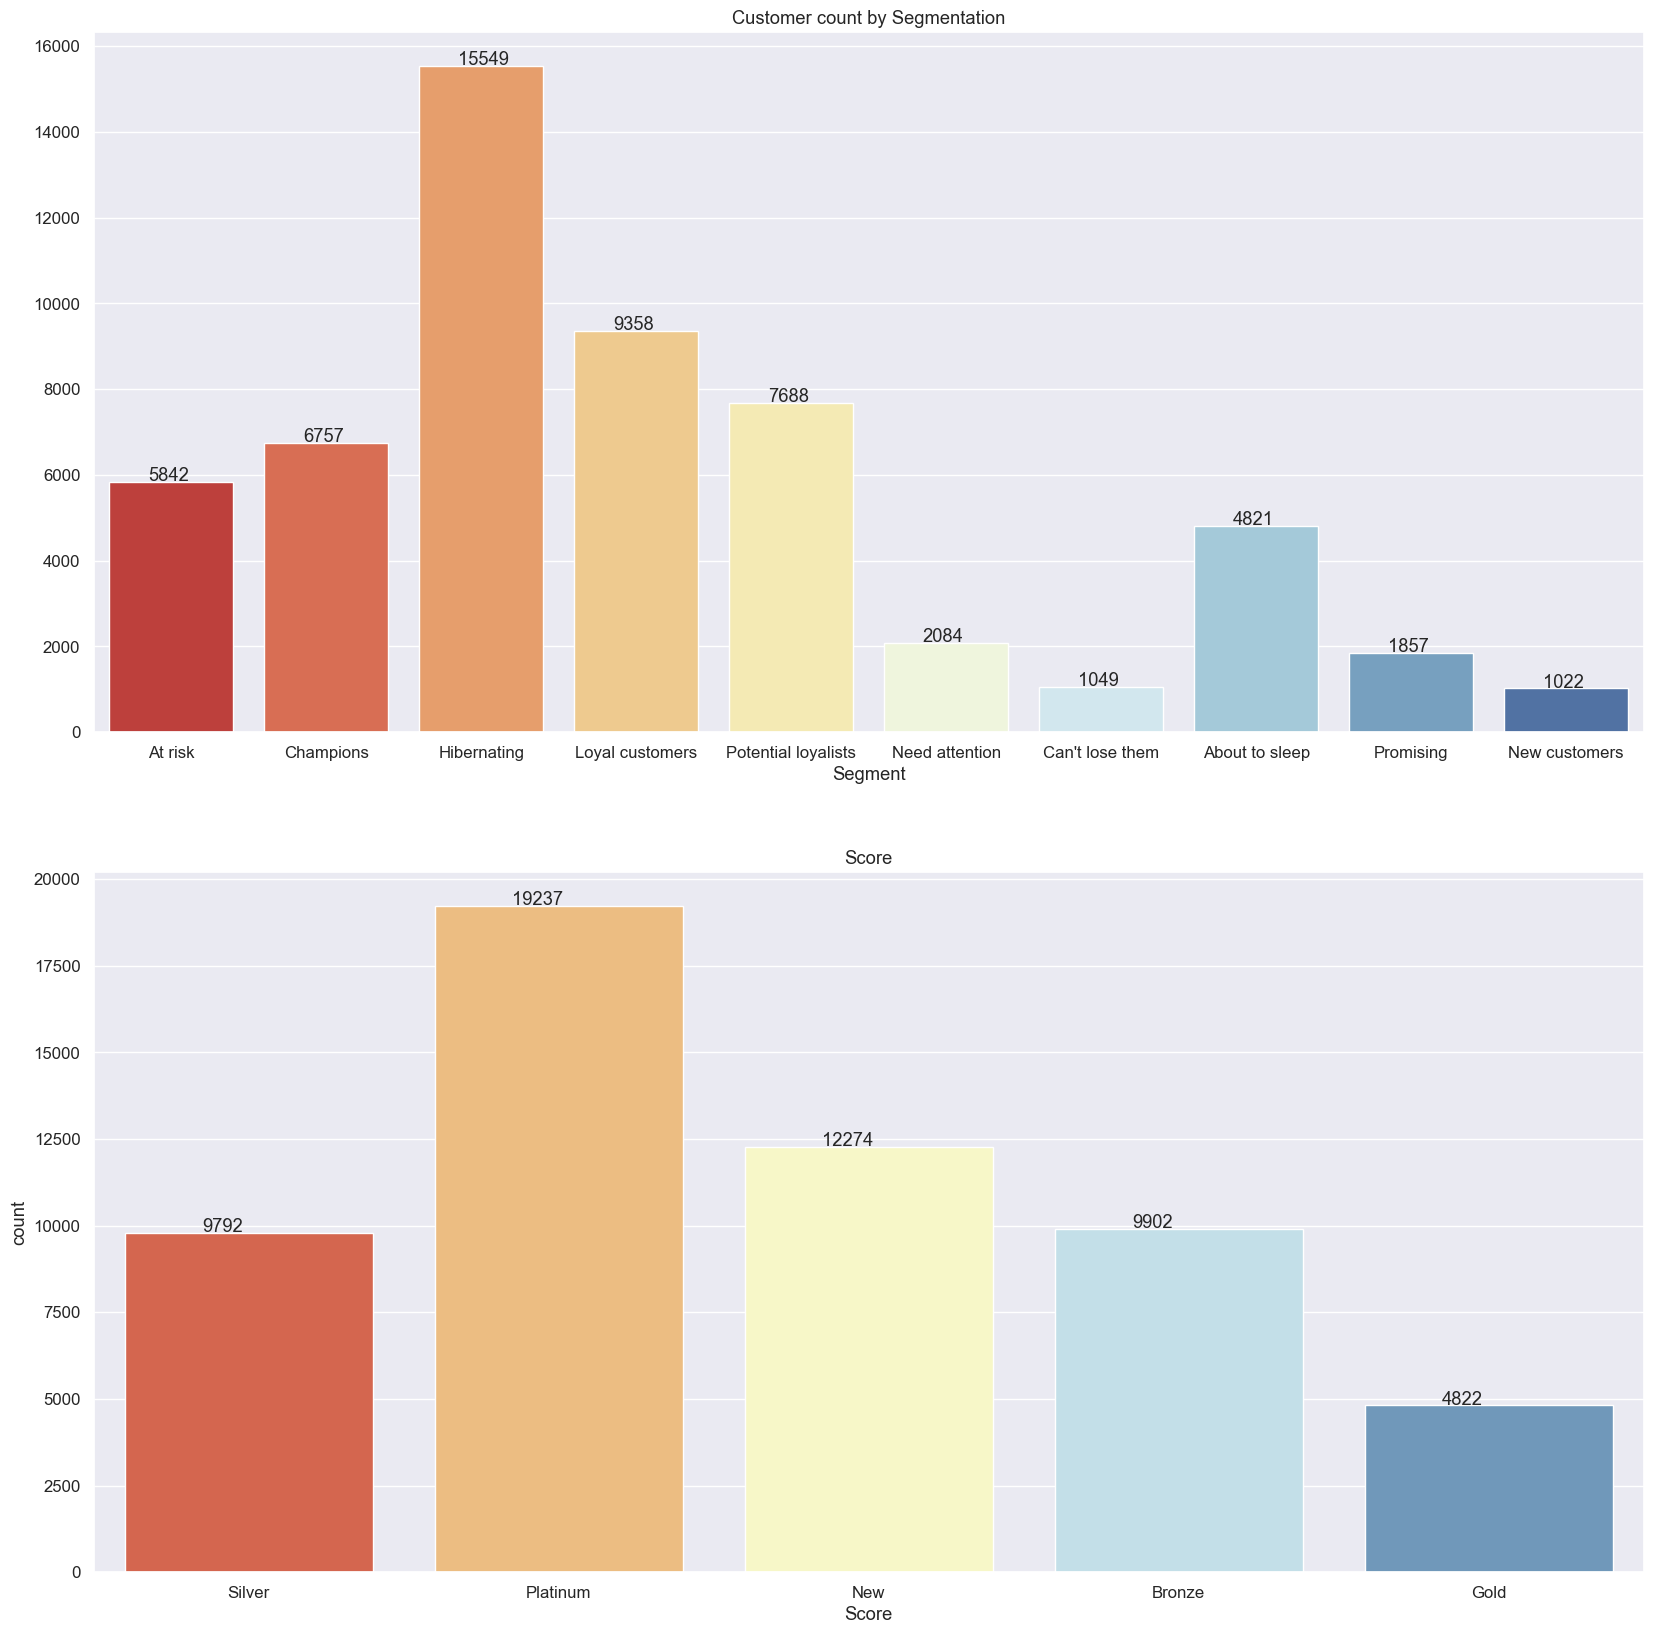

In [46]:
sns.set(font_scale=1.1)

fig, axes = plt.subplots(2, 1, figsize=(20,20))
sns.countplot(x='Segment', data=rfm_seg, ax=axes[0], palette='RdYlBu')
axes[0].set_title('Segment')
axes[0].set_ylabel('')
axes[0].set_title('Customer count by Segmentation')

sns.countplot(x='Score', data=rfm_seg, ax=axes[1], palette='RdYlBu')
axes[1].set_title('Score')

for p in axes[0].patches:
    axes[0].annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+20))

for p in axes[1].patches:
    axes[1].annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+20))

plt.show()

In [67]:
rfm_seg = spark.createDataFrame(rfm_seg)

rfm_final = (
    rfm_seg
        .groupBy(['Cluster', 'Segment'])
        .agg(count('Customer ID').alias('Customer Count'))
        .withColumn('Pct Customer Count', round((col('Customer Count')/sum('Customer Count').over(Window.partitionBy('Cluster')))*100, 2))
        .select('Cluster', 'Segment', 'Customer Count', 'Pct Customer Count')
        .orderBy('Cluster')
)


In [69]:
rfm_final.show(30,truncate=False)

+-------+-------------------+--------------+------------------+
|Cluster|Segment            |Customer Count|Pct Customer Count|
+-------+-------------------+--------------+------------------+
|0      |Champions          |624           |5.64              |
|0      |Need attention     |234           |2.12              |
|0      |Potential loyalists|6388          |57.75             |
|0      |Loyal customers    |486           |4.39              |
|0      |About to sleep     |1042          |9.42              |
|0      |New customers      |1019          |9.21              |
|0      |Promising          |1269          |11.47             |
|1      |Need attention     |46            |0.33              |
|1      |Loyal customers    |6354          |46.01             |
|1      |Champions          |6133          |44.41             |
|1      |Potential loyalists|1016          |7.36              |
|1      |Can't lose them    |238           |1.72              |
|1      |At risk            |16         